In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys


In [3]:
# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [12]:
df, dfc, tensor, static = create_region_df_dfc_static(region, year)
au_df, au_dfc, au_tensor, au_static = create_region_df_dfc_static("Austin", 2014)
sd_df, sd_dfc, sd_tensor, sd_static = create_region_df_dfc_static("SanDiego", 2014)

au_L = get_L(au_static)
sd_L = get_L(sd_static)
T_constant = np.ones(12).reshape(-1, 1)

In [ ]:
n_splits = 10
kf = KFold(n_splits=n_splits)

num_home_factor = 4
num_season_factor = 3
case = 2
prediction = {}
num_iterations = 5
num_random_seed = 5

for random_seed in range(num_random_seed):
    prediction[random_seed] = {}
    for iterations in range(num_iterations):
        prediction[random_seed][iterations] = {}
        for appliance in APPLIANCES_ORDER:
            prediction[random_seed][iterations][appliance] = []
        
# Weight matrix for Austin Data
m, n, o = au_tensor.shape
weight_matrix = np.ones((m,n,o))

adapt_percentage = 50
for random_seed in range(num_random_seed):
    random.seed(random_seed)
    
    for adapt_max, test in kf.split(sd_df):
        
        np.random.seed(10*random_seed + int(adapt_percentage)/10)
        np.random.shuffle(adapt_max)
        
        
        # prepare for the adapt data and test data in SanDiego
        num_test = len(test)
        num_adapt = int((adapt_percentage * len(adapt_max) / 100) + 0.5)

        if adapt_percentage == 100:
            adapt = adapt_max 
        else:
            adapt, _ = train_test_split(adapt_max, train_size=adapt_percentage / 100.0)

        adapt_ix = sd_df.index[adapt]
        test_ix = sd_df.index[test]

        weight_matrix = np.ones((m,n,o))
       

        for iteration in range(num_iterations):
            print 'iteration:', iteration
#             print weight_matrix
            # train A_au with au_tensor
            tensor_copy = au_tensor.copy()
            H_train, A_train, T_train, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       au_L,
                                                                      num_home_factor,
                                                                      num_season_factor,
                                                                     weight_matrix,
                                                                      num_iter=2000,
                                                                      lr=0.1, dis=True,
                                                                      lam=0,
                                                                      T_known=T_constant)

            # create the adapt-test tensor for SanDiego
            test_adapt_ix = np.concatenate([test_ix, adapt_ix])
            ta_df = sd_df.loc[test_adapt_ix]
            ta_tensor = get_tensor(ta_df)

            weight_ta = np.ones(ta_tensor.shape)
            L_ta = sd_L[np.ix_(np.concatenate([test, adapt]), np.concatenate([test, adapt]))]

            # adapt the A_train to SanDiego
            tensor_copy = ta_tensor.copy()
            H_ta, A_ta, T_ta, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       L_ta,
                                                                      num_home_factor,
                                                                      num_season_factor,
                                                                     weight_ta,
                                                                      num_iter=2000,
                                                                      lr=0.1, dis=True,
                                                                      lam=0,
                                                                    A_known = A_train,
                                                                      T_known=T_constant)



            # save the result for this iteration.
            HAT = multiply_case(H_ta, A_ta, T_ta, case)
            for appliance in APPLIANCES_ORDER:
                prediction[random_seed][iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))

            # update weight matrix for training data
            H_tr_v = np.r_[H_train, H_ta[num_test:]]

            similarities = cosine_similarity(H_tr_v)
            sim = similarities[:len(H_train), len(H_train):]
            sim = sim.max(axis=1)
            
            weight = (sim-sim.min())/(sim.max() - sim.min())
#             print weight
            weight_matrix = np.repeat(weight.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)

iteration: 0
498.390915785
140.09512203
101.379737927
88.5219212457
223.907438892
41.4349756887
38.0393089169
37.2647128595
iteration: 1
461.579156412
126.985593609
90.4764935821
79.5607302406
223.800689445
41.3311657122
38.0821672567
37.3318306329
iteration: 2
443.236289669
120.666162672
85.6916189076
75.3178591777
223.749343027
41.3044515564
38.1005615727
37.3567703862
iteration: 3
472.523149108
131.076218263
93.908365645
82.3073066578
223.83780114
41.3496139595
38.0618354241
37.3019337022
iteration: 4
472.662090893
131.012515165
93.8046930774
82.3327515405
223.837498748
41.3489280216
38.0639617133
37.3045964806
iteration: 0
498.390915785
140.09512203
101.379737927
88.5219212457
228.233894232
40.9684005045
37.5007427967
36.7940268764
iteration: 1
452.408862083
123.972766231
88.2246106491
77.9434987685
228.12249661
40.8963324895
37.5955356507
36.8874772702
iteration: 2
445.712525264
121.798643677
86.4292667109
76.5088127365
228.111692854
40.8865386758
37.6025654325
36.8928257292
itera

124.86161591
89.0025765401
78.5123708404
191.850841975
35.7059501518
33.9407298522
33.5615003177
iteration: 2
444.617159596
121.549166529
86.4756526224
76.4683246326
191.831193243
35.7179143621
33.9680695162
33.5896435857
iteration: 3
444.63606501
121.928397172
87.0544227267
76.4120478779
191.829653702
35.6964948984
33.9438246921
33.5654119817
iteration: 4
444.752749282
121.743227663
86.6477893567
76.489303312
191.836209322
35.711462722
33.9580727304
33.5791530183
iteration: 0
498.390915785
140.09512203
101.379737927
88.5219212457
178.350864837
35.4579906188
33.4980111868
33.078804143
iteration: 1
470.193906412
129.94442432
93.3824673563
82.015399698
178.288754288
35.4135386362
33.5761429518
33.1762489179
iteration: 2
451.56494403
123.711660441
88.4320568345
78.0056217641
178.249755254
35.4181527894
33.6220949934
33.2302015861
iteration: 3
466.535185752
128.941287142
92.6674424814
81.4763490899
178.285753569
35.4315062901
33.5907825108
33.1881266734
iteration: 4
460.815594832
126.93685

89.9358308069
79.7143701579
200.129234113
34.0654063537
31.2749393413
30.6036397252
iteration: 3
476.929741273
132.105903217
94.8950847386
83.6024558526
200.178175837
34.10200785
31.2683900909
30.5995538844
iteration: 4
461.064897169
126.291896429
90.2192533912
79.9341018828
200.131611462
34.0657672106
31.2739935468
30.6032288089
iteration: 0
498.390915785
140.09512203
101.379737927
88.5219212457
196.353365583
34.2077674954
31.1378899086
30.413692846
iteration: 1
476.833332951
132.11570734
94.8802108556
83.4352228917
196.29553831
34.1620149483
31.164998933
30.4455671636
iteration: 2
459.375101643
125.841300883
89.794801312
79.3073715722
196.244550461
34.1317102409
31.1870824585
30.4718132406
iteration: 3
477.002371738
132.246759159
94.9319342413
83.4592163199
196.29620737
34.1832012102
31.1869176164
30.4689173437
iteration: 4
460.773556924
126.377053305
90.2014503992
79.6350583573
196.248713551
34.1287993313
31.1817033077
30.4670177999
iteration: 0
498.390915785
140.09512203
101.379737

82.6745567482
201.323854914
33.7128778984
31.3617350201
30.9065890023
iteration: 4
459.331354176
126.935518189
90.9530454575
80.9035551177
201.295504186
33.7465635494
31.4017644149
30.9426258196
iteration: 0
498.390915785
140.09512203
101.379737927
88.5219212457
190.54881769
33.5486276934
31.5996400511
31.1878490806
iteration: 1
468.005150357
129.585875623
92.99444788
81.8600912642
190.475476493
33.5472658719
31.6715938569
31.2745448705
iteration: 2
458.12500546
126.365624545
90.3321802343
79.7209415335
190.44869692
33.5508312321
31.6929743614
31.2985947692
iteration: 3
465.604491168
128.785984303
92.3081432717
81.3574431982
190.470401733
33.545610408
31.6779683457
31.2828151993
iteration: 4
457.612124765
126.128729053
90.1939536879
79.5989365616
190.446615093
33.5525875758
31.6960849243
31.3018197843
iteration: 0
498.390915785
140.09512203
101.379737927
88.5219212457
190.204864699
33.8917213411
31.9947534775
31.5535794607
iteration: 1
468.858623707
129.343474897
92.9015655435
81.91146

In [13]:
out = {}
for random_seed in range(num_random_seed):
    out[random_seed] = {}
    for iteration in range(num_iterations):
        out[random_seed][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            out[random_seed][iteration][appliance] = {}

            print random_seed, adapt_percentage, iteration, appliance
            s = pd.concat(prediction[random_seed][iteration][appliance]).loc[sd_df.index]
            if appliance=="hvac":
                out[random_seed][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[random_seed][iteration][appliance] = compute_rmse_fraction(appliance, s, 'SanDiego')[2]

0 50 0 hvac
0 50 0 fridge
0 50 0 mw
0 50 0 dw
0 50 0 wm
0 50 0 oven
0 50 1 hvac
0 50 1 fridge
0 50 1 mw
0 50 1 dw
0 50 1 wm
0 50 1 oven
0 50 2 hvac
0 50 2 fridge
0 50 2 mw
0 50 2 dw
0 50 2 wm
0 50 2 oven
0 50 3 hvac
0 50 3 fridge
0 50 3 mw
0 50 3 dw
0 50 3 wm
0 50 3 oven
0 50 4 hvac
0 50 4 fridge
0 50 4 mw
0 50 4 dw
0 50 4 wm
0 50 4 oven
1 50 0 hvac
1 50 0 fridge
1 50 0 mw
1 50 0 dw
1 50 0 wm
1 50 0 oven
1 50 1 hvac
1 50 1 fridge
1 50 1 mw
1 50 1 dw
1 50 1 wm
1 50 1 oven
1 50 2 hvac
1 50 2 fridge
1 50 2 mw
1 50 2 dw
1 50 2 wm
1 50 2 oven
1 50 3 hvac
1 50 3 fridge
1 50 3 mw
1 50 3 dw
1 50 3 wm
1 50 3 oven
1 50 4 hvac
1 50 4 fridge
1 50 4 mw
1 50 4 dw
1 50 4 wm
1 50 4 oven
2 50 0 hvac
2 50 0 fridge
2 50 0 mw
2 50 0 dw
2 50 0 wm
2 50 0 oven
2 50 1 hvac
2 50 1 fridge
2 50 1 mw
2 50 1 dw
2 50 1 wm
2 50 1 oven
2 50 2 hvac
2 50 2 fridge
2 50 2 mw
2 50 2 dw
2 50 2 wm
2 50 2 oven
2 50 3 hvac
2 50 3 fridge
2 50 3 mw
2 50 3 dw
2 50 3 wm
2 50 3 oven
2 50 4 hvac
2 50 4 fridge
2 50 4 mw
2 50 4 dw
2 

In [14]:

mean_out = pd.Panel(out).mean(axis=0)
# out[0]

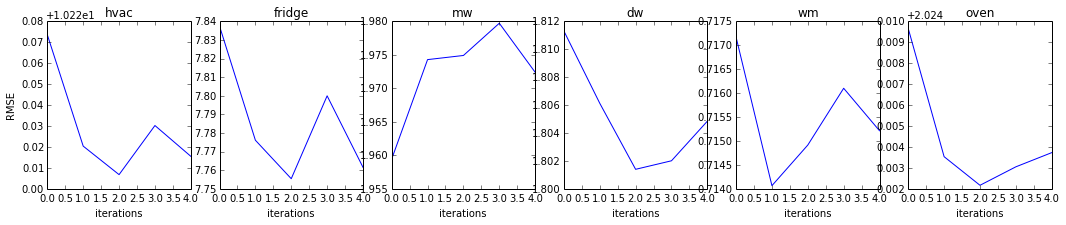

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,3))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
    mean_out.T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlim([0,4])
    ax[count].set_xlabel("iterations")
    count += 1
ax[0].set_ylabel("RMSE")   
# plt.xlabel("iterations")
plt.savefig("TransferLearningSelectiveAppliance.pdf")

In [16]:
mean_out

,0,1,2,3,4
dw,1.811314,1.806133,1.801397,1.802008,1.804848
fridge,7.837504,7.776119,7.755427,7.799983,7.761551
hvac,10.293611,10.240395,10.226777,10.250238,10.235527
mw,1.959444,1.974293,1.974911,1.979725,1.972399
oven,2.033661,2.027535,2.026168,2.027050,2.027728
wm,0.717172,0.714066,0.714915,0.716102,0.715213


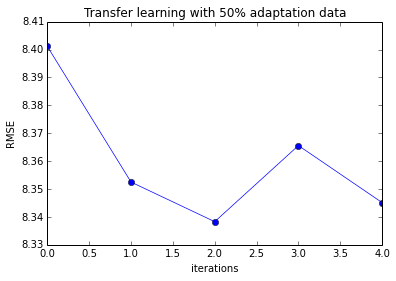

In [24]:
fig, ax = plt.subplots()
error = (pd.DataFrame(mean_out.T)*pd.Series(contri['SanDiego'])).sum(axis=1)
error.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
ax.set_xlabel("iterations")
ax.set_ylabel("RMSE")
ax.set_title("Transfer learning with 50% adaptation data")
plt.savefig("TransferLearningwith50AdaptationData.pdf", format='pdf')

In [5]:
import pickle
out_file = pickle.load(open("./out.pkl"))
mean_out_file = pd.Panel(out_file).mean(axis=0)



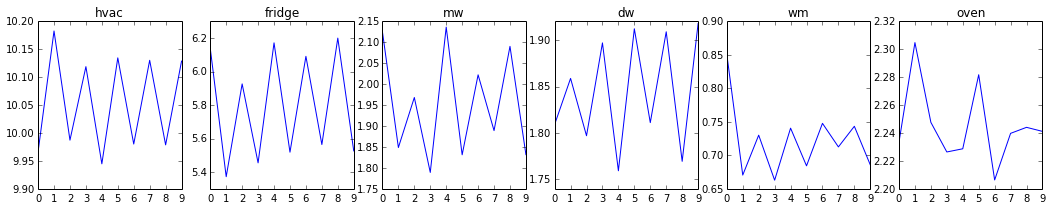

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,3))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
    mean_out_file.T[appliance].plot(ax = ax[count], title=appliance)
    count += 1
#     ax[count].set_xlim([0,4])

# plt.savefig("Result_remove_cluster.png")

In [5]:
n_splits = 10
kf = KFold(n_splits=n_splits)

num_home_factor = 2
num_season_factor = 3
case = 2
prediction = {}
num_iterations = 5
num_random_seed = 1

for random_seed in range(num_random_seed):
    prediction[random_seed] = {}
    for iterations in range(num_iterations):
        prediction[random_seed][iterations] = {}
        for appliance in APPLIANCES_ORDER:
            prediction[random_seed][iterations][appliance] = []
        


for random_seed in range(num_random_seed):
    random.seed(random_seed)
    
    for train_validate, test in kf.split(df):
            
        num_train_validate = len(train_validate)
        num_test = len(test)
            
        # randomly select the validation data
        # may need more iterations for different random values
        validate = random.sample(train_validate, int(0.1*num_train_validate))
        train = list(set(train_validate) - set(validate))
        
        # get the index of train, validation and test data
        train_ix = df.index[train]
        test_ix = df.index[test]
        validate_ix = df.index[validate]
        
        #####################################################
#         # set initial selected data and removed data
#         selected = train
#         removed = list(set(train) - set(selected))
#         selected_ix = df.index[selected]
#         removed_ix = df.index[removed]
        #####################################################
        
        for iteration in range(num_iterations):
            
            print 'Iteration: ', iteration
#             num_test = len(test)
#             num_selected = len(selected)
#             num_validate = len(validate)
            num_train = len(train)
            num_test = len(test)
            num_validate = len(validate)
            
            ############################################################################
#             selected_ix = df.index[selected]
#             removed_ix = df.index[removed]
            
#             L_inner = L[np.ix_(np.concatenate([test, selected, validate]), np.concatenate([test, selected, validate]))]
#             selected_validate_test_ix = np.concatenate([test_ix, selected_ix, validate_ix])
#             df_inner, dfc_inner = df.loc[selected_validate_test_ix], dfc.loc[selected_validate_test_ix]
#             tensor = get_tensor(df_inner)
            ################################################################################
            
            test_train_validate_ix = np.concatenate([test_ix, train_ix, validate_ix])
            df_inner = df.loc[test_train_validate_ix]
            tensor = get_tensor(df_inner)
            tensor_copy = tensor.copy()
            # set appliances' readings of test data to be MISSING
            tensor_copy[:num_test, 1:, :] = np.NaN
#             m, n, o = tensor_copy.shape
#             weight_matrix = tensor.copy()
#             weight_matrix[:,:,:]=1
            if iteration == 0: 
                m, n, o = tensor_copy.shape
                weight_matrix = tensor.copy()
                weight_matrix[:, :, :] = 1
            
            # Learn the model
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                       L,
                                                                      num_home_factor,
                                                                      num_season_factor,
                                                                       weight_matrix,
                                                                      num_iter=1300,
                                                                      lr=0.1, dis=True,
                                                                      lam=0,
                                                                      T_known=T_constant)
            
            # save the result for this iteration.
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                prediction[random_seed][iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
                
            
            H_train = H[num_test:(num_test+num_train), :]
            H_validate = H[(num_test + num_train):, :]
            
            similarities = cosine_similarity(H[num_test:, :])
            sim = similarities[:num_train, num_train:]
#             print sim.shape
            sim = sim.mean(axis=1)
            print sim.shape
            weight = np.r_[np.ones(num_test), sim, np.ones(num_validate)]
            print weight.shape
            weight_matrix = np.repeat(weight.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    
            
            
            
            ##############################################################################################
            # Only consider the home factors learned to select data
#             H_validate = H[(num_test + num_selected):, :]
#             H_selected = H[num_test:(num_test + num_selected), :]
#             H_combine = np.r_[H_selected, H_validate]
#             H_combine = H_combine/np.max(H_combine)
#             cluster_pred = KMeans(n_clusters = 20, random_state = 0).fit_predict(H_combine)
#             selected_cluster = set(cluster_pred[:num_selected])
#             validate_cluster = set(cluster_pred[num_selected:])

            
#             selected = [i for i, j in enumerate(cluster_pred[:num_selected]) if j in validate_cluster]
#             removed = list(set(train) - set(selected))
            ##############################################################################################

Iteration:  0
519.448894999
181.759463335
113.080981643
(432,)
(533,)
Iteration:  1
499.547152936
174.307121416
108.59539905
(432,)
(533,)
Iteration:  2
499.882182743
174.437762952
108.675234846
(432,)
(533,)
Iteration:  3
499.881525842
174.437291635
108.674950475
(432,)
(533,)
Iteration:  4
499.881819054
174.437406745
108.67501253
(432,)
(533,)
Iteration:  0
514.090255833
179.343965453
111.205457742
(432,)
(533,)
Iteration:  1
498.008931725
173.234797336
107.165620404
(432,)
(533,)
Iteration:  2
498.814134513
173.537297384
107.359697598
(432,)
(533,)
Iteration:  3
498.814480759
173.536894678
107.359388315
(432,)
(533,)
Iteration:  4
498.815240022
173.537195883
107.359569211
(432,)
(533,)
Iteration:  0
517.038016556
179.33248519
111.596478323
(432,)
(533,)
Iteration:  1
496.691317735
171.828685833
106.799301202
(432,)
(533,)
Iteration:  2
497.471302926
172.115507513
106.981959308
(432,)
(533,)
Iteration:  3
497.462001176
172.112048306
106.979778738
(432,)
(533,)
Iteration:  4
497.46420

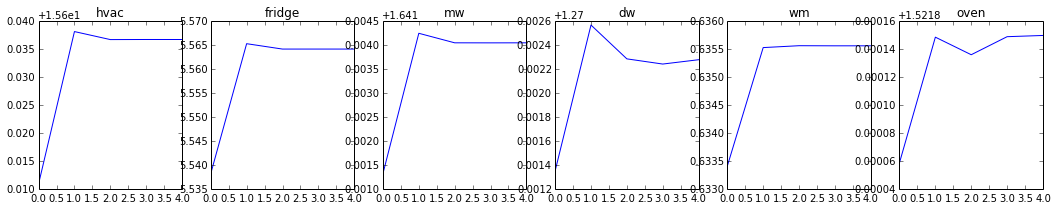

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,3))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
    mean_out.T[appliance].plot(ax = ax[count], title=appliance)
    count += 1

# plt.savefig("Result_remove_cluster.png")

In [5]:
tensor_copy = source_tensor.copy()
tensor_copy[:, 1:, :] = np.NaN

In [10]:
from degree_days import dds

#For HVAC

In [11]:
def get_tensor_appliance(df, dfc, appliance):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] ]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 1, stop - start))
    M, N, O = tensor.shape
    return tensor

In [50]:
hvac_tensor = get_tensor_appliance(source_df, source_dfc, 'fridge')
agg_tensor = get_tensor_appliance(source_df, source_dfc, 'aggregate')
tensor = np.concatenate((agg_tensor, hvac_tensor), axis=1)

In [73]:
known_homes = []
random_list =  random.sample(range(num_train), 50)
random_list =[x+1 for x in random_list]

pos = random_list[:50]
known_homes = known_homes+pos
# aggregate readings for all homes are known


In [ ]:
def compute_rmse_fraction(appliance, pred_df, region='Austin', year=2014):
	appliance_df = create_matrix_region_appliance_year(region, year, appliance)

	if appliance == "hvac":
		start, stop = 5, 11
	else:
		start, stop = 1, 13
	pred_df = pred_df.copy()
	pred_df.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
	gt_df = appliance_df[pred_df.columns].ix[pred_df.index]

	aggregate_df = appliance_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]

	aggregate_df.columns = gt_df.columns
	rows, cols = np.where((aggregate_df < 100))
	for r, c in zip(rows, cols):
		r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
		aggregate_df.loc[r_i, c_i] = np.NaN

	gt_fraction = gt_df.div(aggregate_df) * 100
	pred_fraction = pred_df.div(aggregate_df) * 100

	# Capping it to 100%
	pred_fraction[pred_fraction > 100] = 100.

	gt_fraction_dropna = gt_fraction.unstack().dropna()
	pred_fraction_dropna = pred_fraction.unstack().dropna()
	index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
	gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
	pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
	difference_error = (gt_fraction_dropna - pred_fraction_dropna).abs()

	rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
	return gt_fraction_dropna, pred_fraction_dropna, rms, difference_error

In [83]:
from scipy.optimize import nnls
from sklearn.model_selection import train_test_split, KFold
import random

random_list =  random.sample(range(533), 533)
random_list =[x+1 for x in random_list]

n_splits = 10
case = 2
a = 3
b = 3
cost = 'abs'
app = 'fridge'
known_homes = []

   
kf = KFold(n_splits=n_splits)

for random_seed in range(1):
    
    random.seed(random_seed)
    
    for train_max, test in kf.split(source_df):
            
            num_train = len(train_max)
            num_test = len(test)

            train = train_max
           
            # get the index of training and testing data
            train_ix = source_df.index[train]
            test_ix = source_df.index[test]
            print "test_ix: ", test_ix

            # create the tensor
            train_test_ix = np.concatenate([train_ix, test_ix])
            df_t, dfc_t = source_df.ix[train_test_ix], source_dfc.ix[train_test_ix]
            app_tensor = get_tensor_appliance(df_t, dfc_t, app)
            agg_tensor = get_tensor_appliance(df_t, dfc_t, 'aggregate')
            
            tensor = np.concatenate((agg_tensor, app_tensor), axis=1)
            
            
            random_list =  random.sample(range(num_train), 50)
            random_list =[x+1 for x in random_list]

            for month in range(1):
                if month == 0:
                    tensor_copy = tensor.copy()
                    tensor_copy[:,:,:] = np.NaN
                    pos = random_list[:50]
                    known_homes = known_homes + pos
                    # aggregate readings for all homes are known
                    tensor_copy[:, 0, :] = tensor[:, 0, :]
                    # appliance readings for selected homes are known
                    tensor_copy[known_homes, 1, :] = tensor[known_homes, 1, :]
                    tensor_copy = tensor_copy[:, :, 0:(month+2)]
                    
                    T_constant = np.ones(month+2).reshape(-1,1)
                    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                                source_L,
                                                                              a,
                                                                              b,
                                                                              num_iter=1300,
                                                                              lr=0.1, dis=True,
                                                                              lam=0,
                                                                              T_known=T_constant)
                else:
                    # Generate tensor_copy
                    tensor_copy = tensor.copy()
                    tensor_copy[:,:,:] = np.NaN
                    known_homes = known_homes + pos
                    # aggregate readings for all homes are known
                    tensor_copy[:, 0, :] = tensor[:, 0, :]
                    # appliance readings for selected homes are known
                    tensor_copy[known_homes, 1, :] = tensor[known_homes, 1, :]
                    tensor_copy = tensor_copy[:, :, 0:(month+2)]
                    
                    ####
                    T_constant = np.ones(month+2).reshape(-1,1)
                    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                                                source_L,
                                                                              a,
                                                                              b,
                                                                              num_iter=1300,
                                                                              lr=0.1, dis=True,
                                                                              lam=0,
                                                                              T_known=T_constant)
                
                ## Get the home ids
                ### Based on the Home factors
                HAT = multiply_case(H, A, T, case)
                
                pred_test = pd.DataFrame(HAT[num_train:, 1, :], index=test_ix)
                rms_test, error_test = compute_rmse_fraction(app, pred_test, 'Austin', 1, month+3)[2:]
                pred_train = pd.DataFrame(HAT[:num_train, 1, :], index=train_ix)
                rms_train, error_train = compute_rmse_fraction(app, pred_train, 'Austin', 1, month+3)[2:]
                
                
                H_train = H[:num_train]
                H_train = H_train/np.max(H_train)
                label = KMeans(n_clusters=10, random_state=0).fit_predict(H_train)
                
                error_home = pd.concat([error_train[appliance + "_{}".format(start)], 
                   error_train[appliance + "_{}".format(start+1)]],axis=1)
                for i in range(start+2, end):
                    error_home = pd.concat([error_home, error_train[appliance + "_{}".format(i)]], axis = 1)
                app = np.sqrt((error_home**2).mean(axis=1))
                
                max_error = 0
                max_cluster = -1
                for i in range(10):
                    index_set = find(label, i)
                    ids = train_ix[k]
                    mean = cluster_mean_error(app, ids)
                    if mean > max_error:
                        max_error = mean
                        max_cluster = i
                



test_ix:  Int64Index([ 22,  26,  48,  59,  68,  77,  86,  93,  94, 101, 114, 115, 121,
            130, 135, 160, 171, 187, 222, 243, 252, 267, 297, 347, 364, 370,
            410, 434, 436, 457, 470, 484, 491, 499, 503, 507, 508, 545, 555,
            580, 585, 624, 645, 661, 668, 739, 744, 772, 781, 861, 871, 878,
            890, 898],
           dtype='int64')
670.983049446
111.941447556
40.8817683068
test_ix:  Int64Index([ 936,  946,  954,  974,  980,  994, 1037, 1069, 1086, 1103, 1105,
            1153, 1169, 1185, 1192, 1202, 1283, 1310, 1314, 1331, 1334, 1403,
            1415, 1463, 1464, 1479, 1500, 1507, 1508, 1551, 1577, 1586, 1589,
            1601, 1617, 1632, 1642, 1681, 1697, 1700, 1714, 1718, 1782, 1790,
            1791, 1792, 1796, 1800, 1801, 1854, 1889, 1947, 1953, 1994],
           dtype='int64')
653.576385008


KeyboardInterrupt: 

In [119]:
train_ix[0]

22

In [91]:
def find(lst, value):
    return [i for i, x in enumerate(lst) if x==value]

In [175]:
from sklearn.cluster import KMeans
H_train = H[:num_train]
print np.max(H_train)
H_train = H_train/np.max(H_train)
label = KMeans(n_clusters=10, random_state=0).fit_predict(H_train)
k = find(label,5)
print k


10.8433883752
[0, 2, 9, 10, 20, 25, 64, 71, 106, 110, 125, 184, 193, 219, 227, 238, 240, 256, 262, 287, 292, 294, 321, 341, 342, 345, 349, 357, 370, 379, 392, 409, 411, 412, 414, 421, 422, 446, 448, 450, 463, 466, 478]


In [176]:
def cluster_mean_error(app_error, index):
    sum_error = 0
    for i in index:
#         print app_error[i]
        if i in app_error.index:
            sum_error += app_error[i]
    return sum_error/len(index)

In [177]:
start = 1
end = 3
appliance = 'fridge'
error_home = pd.concat([error_train[appliance + "_{}".format(start)], 
                   error_train[appliance + "_{}".format(start+1)]],axis=1)

for i in range(start+2, end):
    error_home = pd.concat([error_home, error_train[appliance + "_{}".format(i)]], axis = 1)
app = np.sqrt((error_home**2).mean(axis=1))

ids = train_ix[k]
mean = cluster_mean_error(app, ids)
print mean

# app.index
# app[936]

5.63938537858


In [46]:
def compute_error(HAT, index, domain):
    pred = {}
    for appliance_name, appliance_id in appliance_index.iteritems():
        pred[appliance_name] = []
        pred[appliance_name].append(pd.DataFrame(HAT[:,appliance_id,:], index=index))
#     print pred
    for appliance_name, appliance_id in appliance_index.iteritems():
        pred[appliance_name] = pd.concat(pred[appliance_name]).ix[index]
    
    
#     pred = pd.DataFrame(pred)
    err_all = {}
    err = {}
    for appliance in APPLIANCES_ORDER[1:]:        
        if appliance=="hvac":
            err_all[appliance], err[appliance] = compute_rmse_fraction(appliance, pred[appliance][range(4, 10)], domain)[2:]
        else:   
            err_all[appliance], err[appliance] = compute_rmse_fraction(appliance, pred[appliance], domain)[2:]

    err_app = {}
    for appliance in APPLIANCES_ORDER[1:]:
        if appliance == 'hvac':
            start, end = 5, 11
        else:
            start, end = 1, 13

        error_home = pd.concat([err[appliance][appliance + "_{}".format(start)], 
                           err[appliance][appliance + "_{}".format(start+1)]],axis=1)

        for i in range(start+2, end):
            error_home = pd.concat([error_home, err[appliance][appliance + "_{}".format(i)]], axis = 1)
        app = np.sqrt((error_home**2).mean(axis=1))
        err_app[appliance] = app

    result = (pd.DataFrame(err_app).fillna(0)*pd.Series(contri[domain])).sum(axis=1)
        
        
    return err_all, result

In [78]:
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=1300,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

927.359618339
327.132788609
174.115738163


In [79]:
H

array([[ 1.66345507,  1.8757803 ,  1.69049574],
       [ 5.56361928,  5.50529646,  5.50663552],
       [ 1.3197905 ,  1.78687358,  1.804727  ],
       ..., 
       [ 2.73141718,  2.82475159,  2.26333804],
       [ 2.24214654,  2.14861078,  2.76485631],
       [ 2.99715369,  3.21232919,  3.28624526]])

In [11]:
err_all, err_home = compute_error(HATs[-1], source_df.index, source)

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


hvac
fridge
mw
dw
wm
oven


In [45]:
source_df.ix[max_index]['aggregate_3']

77.594146728515625

In [17]:
k = ((pd.Series(err_all) * pd.Series(contri['Austin']))).sum()# error = (pd.DataFrame(out)*pd.Series(contri['SanDiego'])).sum(axis=1)

In [21]:
max_index = err_home.argmax()

In [40]:
position = source_df.index.get_loc(max_index)

In [42]:
tensor_copy[position] = source_tensor[position]

In [74]:
import random
random.seed(5)
random_list =  random.sample(range(533), 533)
random_list =[x+1 for x in random_list]

In [77]:
prediction_error = []

tensor_copy = source_tensor.copy()
tensor_copy[:, 1:, :] = np.NaN
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=1300,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                      T_known=T_constant)
err_all, err_home = compute_error(HATs[-1], source_df.index, source)
overall_error = ((pd.Series(err_all) * pd.Series(contri['Austin']))).sum()
print overall_error

for i in range(20):
    max_index = err_home.argmax()
    position = source_df.index.get_loc(max_index)
#     position = random_list[i]
    print position
    tensor_copy[position] = source_tensor[position]
    
    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=1300,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          T_known=T_constant)
    err_all, err_home = compute_error(HATs[-1], source_df.index, source)
    overall_error = ((pd.Series(err_all) * pd.Series(contri['Austin']))).sum()
    print i, overall_error

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


26.1021914905
61
0 22.1222043053
47
1 19.8106416228
476
2 18.4501308997
178
3 16.5123081787
518
4 17.1332797771
494
5 17.0051122383
45
6 16.8313282303
318
7 14.7923720999
131
8 14.7421349938
346
9 14.6333198034
153
10 13.6021757488
59
11 13.596117084
439
12 13.4803772491
425
13 13.5001449042
494
14 13.5001449042
494
15 13.5001449042
494
16 13.5001449042
494
17 13.5001449042
494
18 13.5001449042
494
19 13.5001449042
